In [2]:
import numpy as np
import pandas as pd
import lightkurve as lk
import os
import tqdm

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('axes', facecolor='white')

In [3]:
kep = pd.read_csv("../tables/kepler_sample_classified.csv")
# tess = pd.read_csv("../tables/tess_sample_unclassified.csv")
tess = pd.read_csv("../tables/tess_feature_predicted_classifications.csv")

In [4]:
# Load in light curve data for both Kepler and TESS
def load_lc(kic, survey='kepler'):
    if survey == 'kepler':
        loaded = np.load(f"../lurie_lc/KIC{str(kic)}.npz")
    elif survey == 'tess':
        loaded = np.load(f"../tess_lc/TIC{str(kic)}.npz")
    lc = lk.LightCurve(time=loaded['time'], flux=loaded['flux'], flux_err=loaded['flux_err']).remove_nans()
    return lc

# Plot a lightcurve 
def plot_lightkurve(surv, obj_id, st_class, orb_period, maxDiff, legend_loc="lower right"):
    
    lc = load_lc(obj_id, survey=surv)
    
    # Sorts the array to fix issues with curve going back and forth at some points
    lc.time.value.sort()
    
    # When there is a gap in observation data, shift all data after that point backwards
    # Difference is in multiples of the orbital period and it can only be shifted in multiples of the orbital period
    offset = 0
    diff = np.diff(lc.time.value)
    for i in range(len(lc.time.value)):
        if i == 0: continue
        if diff[i - 1] >= maxDiff * orb_period:
            offset += diff[i - 1] - (diff[i - 1] % orb_period)
        lc.time.value[i] -= offset

    p1 = np.percentile(lc.flux.value, 1)
    p2 = np.percentile(lc.flux.value, 99)
    sd = np.std(lc.flux.value)
    upper_margin = 3
    lower_margin = 7
        
    # Plot the lightcurve without folding applied
    fig, ax = plt.subplots(3, 1, figsize=[16,16])
    plt.subplots_adjust(hspace=0.5)
    
    ax[0].plot(lc.time.value, lc.flux.value, color='k', linewidth=1, label=f"OBJ ID: {obj_id}")
    ax[0].set_xlabel("Time [days]", fontsize=25)
    ax[0].set_ylabel("Flux", fontsize=25)
    ax[0].set_title("Raw Lightcurve", fontsize=25)
    ax[0].set_ylim(p1-(lower_margin*sd), p2+(upper_margin*sd))
    ax[0].set_xlim(min(lc.time.value), max(lc.time.value))
    ax[0].legend(loc=legend_loc, fontsize=25)

    # Plot the folded version of the light curve
    lcf = lc.fold(period=orb_period)
    ax[1].plot(lcf.time.value, lcf.flux.value, color='k', linewidth=1, label=f"Class: {st_class}")
    ax[1].set_xlabel("Time [days]", fontsize=25)
    ax[1].set_ylabel("Flux", fontsize=25)
    ax[1].set_title("Folded", fontsize=25)
    ax[1].set_ylim(p1-(lower_margin*sd), p2+(upper_margin*sd))
    ax[1].set_xlim(min(lcf.time.value), max(lcf.time.value))
    ax[1].legend(loc=legend_loc, fontsize=25)
    
    # Plot just one period
    ax[2].set_title("Single Period", fontsize=25)
    ax[2].plot(lc.time.value, lc.flux.value, color='k', linewidth=1, label=f"Period: {str(orb_period)}")
    ax[2].set_xlabel("Time [days]", fontsize=25)
    ax[2].set_ylabel("Flux", fontsize=25)
    ax[2].set_ylim(p1-(lower_margin*sd), p2+(upper_margin*sd))
    ax[2].set_xlim(min(lc.time.value), min(lc.time.value)+2*orb_period)
    ax[2].legend(loc=legend_loc, fontsize=25)
    plt.close()
    
    return fig

In [ ]:
for ii in tqdm.tqdm(range(len(kep))):
    try:
        obj_id = kep['KIC'][ii]
        st_class = kep['Class'][ii]
        orb_period = kep['Porb'][ii]
        maxDiff = 10
        
        directory = f"../kepler_plots/{st_class}/"
        if not os.path.exists(directory):
            os.mkdir(directory)
        if not os.path.exists(directory + f"KIC{obj_id}.png"):
            fig = plot_lightkurve("kepler", obj_id, st_class, orb_period, maxDiff, legend_loc="lower right")
            fig.savefig(directory + f"KIC{obj_id}.png")
    except:
        print(obj_id)

 21%|█████████████▏                                                 | 476/2272 [02:32<1:03:29,  2.12s/it]

5285607


 21%|█████████████▌                                                 | 487/2272 [02:57<1:24:32,  2.84s/it]

5306862
5308778


 23%|██████████████▍                                                | 520/2272 [04:12<1:21:30,  2.79s/it]

5450814
5456023
5460835


 23%|██████████████▉                                                  | 524/2272 [04:13<35:14,  1.21s/it]

5462901


 23%|██████████████▋                                                | 530/2272 [04:28<1:05:43,  2.26s/it]

In [ ]:
for ii in tqdm.tqdm(range(len(tess))):
    try:
        obj_id = tess['TIC'][ii]
        st_class = tess['predicted_class'][ii]
        orb_period = tess['period_x'][ii]
        maxDiff = 10

        directory = f"../tess_plots/{st_class}/"
        if not os.path.exists(directory):
            os.mkdir(directory)
        if not os.path.exists(directory + f"TIC{obj_id}.png"):
            fig = plot_lightkurve("tess", obj_id, st_class, orb_period, maxDiff, legend_loc="lower right")
            fig.savefig(directory + f"TIC{obj_id}.png")
    except:
        print(obj_id)

 14%|████████▉                                                      | 528/3712 [07:39<2:31:48,  2.86s/it]

In [7]:
tess.keys()

Index(['Unnamed: 0', 'Unnamed: 0_x', 'amplitude',
       'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35',
       'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65',
       'flux_percentile_ratio_mid80', 'percent_difference_flux_percentile',
       'percent_beyond_1_std', 'skew', 'std', 'stetson_j', 'stetson_k',
       'weighted_average', 'median_absolute_deviation', 'period_fast', 'KIC',
       'TIC', 'morph_x', 'period_x', 'BP-RP', 'Gmag', 'RUWE',
       'predicted_class', 'Unnamed: 0_y', 'period_y', 'morph_y', 'RA', 'DEC'],
      dtype='object')

In [7]:
list(kep.keys())

['Unnamed: 0',
 'col1',
 'KIC',
 'Porb',
 'Class',
 'PACF',
 'hACF',
 'P1min',
 'P1max',
 'P2min',
 'P2max',
 'h1min',
 'h1max',
 'h2min',
 'h2max',
 'Note',
 'period',
 'period_err',
 'morph',
 'RA',
 'DEC',
 'GLon',
 'GLat',
 'kmag',
 'Teff',
 'DR3Name',
 'RAdeg',
 'DEdeg',
 'errHalfMaj',
 'errHalfMin',
 'errPosAng',
 'SolID',
 'Source',
 'RandomI',
 'e_RAdeg',
 'e_DEdeg',
 'Plx',
 'e_Plx',
 'RPlx',
 'PM',
 'pmRA',
 'e_pmRA',
 'pmDE',
 'e_pmDE',
 'RADEcor',
 'RAPlxcor',
 'RApmRAcor',
 'RApmDEcor',
 'DEPlxcor',
 'DEpmRAcor',
 'DEpmDEcor',
 'PlxpmRAcor',
 'PlxpmDEcor',
 'pmRApmDEcor',
 'NAL',
 'NAC',
 'NgAL',
 'NbAL',
 'gofAL',
 'chi2AL',
 'epsi',
 'sepsi',
 'Solved',
 'APF',
 'nueff',
 'pscol',
 'e_pscol',
 'RApscolCorr',
 'DEpscolCorr',
 'PlxpscolCorr',
 'pmRApscolCorr',
 'pmDEpscolCorr',
 'MatchObsA',
 'Nper',
 'amax',
 'MatchObs',
 'IPDgofha',
 'IPDgofhp',
 'IPDfmp',
 'IPDfow',
 'RUWE',
 'Dup',
 'o_Gmag',
 'FG',
 'e_FG',
 'RFG',
 'Gmag',
 'e_Gmag',
 'o_BPmag',
 'FBP',
 'e_FBP',
 'R

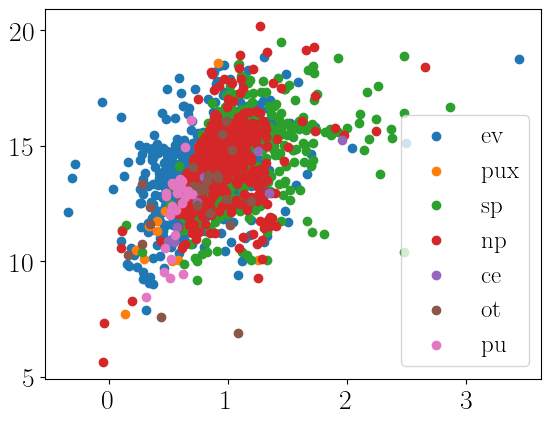

In [13]:
for ctype in set(kep['Class']):
    sel = kep[kep['Class'] == ctype]
    plt.scatter(sel['BP-RP'], sel['Gmag'], label=ctype)
plt.legend(loc='best', fontsize=18)